In [1]:
"""
基于滑动窗口的欧拉反卷积算法

通过基于滑动窗的欧拉反卷积方法估计简单异常模型的坐标。
该方法的使用条件是源要具有简单的几何形状，如球体, 垂直柱体,垂直板状体等。当异常源很复杂的时候，该方法效果不是很理想。
该程序通过常见的滑动窗口方案来测试欧拉反卷积

方案实现于：geoist.euler_moving_window.ipynb。
"""
from geoist.pfm import sphere, pftrans, euler, giutils
from geoist import gridder
from geoist.inversion import geometry
from geoist.vis import giplt
import matplotlib.pyplot as plt

In [2]:
##合成磁数据测试欧拉反卷积
# 磁倾角，磁偏角
inc, dec = -45, 0
# 制作仅包含感应磁化的两个球体模型
model = [
    geometry.Sphere(x=-1000, y=-1000, z=1500, radius=1000,
                  props={'magnetization': giutils.ang2vec(2, inc, dec)}),
    geometry.Sphere(x=1000, y=1500, z=1000, radius=1000,
                  props={'magnetization': giutils.ang2vec(1, inc, dec)})]

print("Centers of the model spheres:")
print(model[0].center)
print(model[1].center)

# 从模型中生成磁数据
shape = (100, 100)
area = [-5000, 5000, -5000, 5000]
x, y, z = gridder.regular(area, shape, z=-150)
data = sphere.tf(x, y, z, model, inc, dec)

# 一阶导数
xderiv = pftrans.derivx(x, y, data, shape)
yderiv = pftrans.derivy(x, y, data, shape)
zderiv = pftrans.derivz(x, y, data, shape)

Centers of the model spheres:
[-1000 -1000  1500]
[1000 1500 1000]


Kept Euler solutions after the moving window scheme:
[[ 1005.02117863  1555.11042642   998.68593456]
 [ 1042.92870628  1479.25104857   982.8034785 ]
 [ -903.03736426  -826.2551998   1580.03357152]
 [ -996.30379977  -940.33986512  1459.01039032]
 [ 1159.1957134   1006.77185575  1199.42292819]
 [ 1465.17965473   408.39773001  1920.31472105]
 [  991.40325194  1468.18742261  1020.67590594]
 [ -966.01139554  -775.38064946  1465.22351287]
 [-1041.3450269   -971.09938734  1500.22185195]
 [ -284.04967711  -382.06786678  2243.58685856]
 [  -35.58602726  -108.90046998  1540.68712849]
 [ 1058.8441761   1516.37801553   994.86866767]
 [  999.08320679  1580.06304764  1051.97367365]
 [ -933.90137199  -995.14775353  1406.97615438]
 [  381.76290333  1131.68128707   992.51158521]
 [  914.43334205  1475.15646829   978.0510579 ]
 [ 1277.82392557  1876.41150747   931.05131937]
 [-1017.82794862 -1140.04437429  1560.46288409]
 [ -991.58404782 -1012.73293178  1556.74635058]
 [ -349.91796733   355.56106336  17

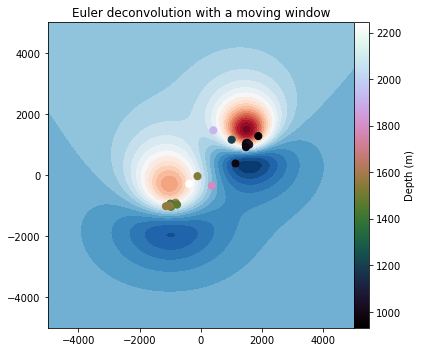

In [3]:
#通过扩展窗方法实现欧拉反卷积 
#给出2个解决方案，每一个扩展窗都靠近异常
#stutural_index=3表明异常源为球体
'''
    ===================================== ======== =========
    源类型                                 SI (磁) SI (重力)
    ===================================== ======== =========
    Point, sphere                            3         2
    Line, cylinder, thin bed fault           2         1
    Thin sheet edge, thin sill, thin dyke    1         0
    ===================================== ======== =========
'''

#选择10 x 10个大小为1000 x 1000 m的窗口
solver = euler.EulerDeconvMW(x, y, z, data, xderiv, yderiv, zderiv,
                             structural_index=3, windows=(10, 10),
                             size=(1000, 1000))
#使用fit()函数来获取右下角异常的估计值
solver.fit()

#估计位置存储格式为一列[x, y, z] 坐标
print('Kept Euler solutions after the moving window scheme:')
print(solver.estimate_)

# 在磁数据上绘制异常估计值结果
# 异常源的中心的真正深度为1500 m 和1000 m。

plt.figure(figsize=(6, 5))
plt.title('Euler deconvolution with a moving window')
plt.contourf(y.reshape(shape), x.reshape(shape), data.reshape(shape), 30,
             cmap="RdBu_r")
plt.scatter(solver.estimate_[:, 1], solver.estimate_[:, 0],
            s=50, c=solver.estimate_[:, 2], cmap='cubehelix')
plt.colorbar(pad=0).set_label('Depth (m)')
plt.xlim(area[2:])
plt.ylim(area[:2])
plt.tight_layout()
plt.show()